# Lab 2: Final

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019

## Ejercicios Lab Final

Se pide:

1) Implementar [Double DQN (DDQN)](https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/view/12389/11847).

2) Implementar [Dueling DDQN](https://arxiv.org/pdf/1511.06581.pdf).

3) Cambiar el entorno por uno nuevo a elección

4) Implementar [Prioritized Experience Replay (PER)](https://arxiv.org/pdf/1511.05952.pdf) (**Opcional**).

**Comentar en un notebook lo realizado paso a paso, mostrando resultados parciales y finales. Y subirlo a un repositorio en GitHub** 

**Recomendación General**: No se sugiere hacer este TP desde jupyter notebook/lab sino desde un IDE estilo "Pycharm" o "Visual Studio Code", debido a que los algoritmos de RL suelen requerir un debug paso a paso, tanto para corregir errores como para entender mejor cómo funcionan los mismos.

**Opcional**: Implementación de un agente DQN convolucional que aprende a jugar a Atari© Space Invaders© ([link](https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Space%20Invaders/DQN%20Atari%20Space%20Invaders.ipynb))

In [1]:
import itertools
import math
import time
import warnings

warnings.simplefilter('ignore')


In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import torch
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F

matplotlib.rcParams['figure.figsize'] = 16, 8
plt.style.use('seaborn-dark')


In [3]:
from agents.utils.memory.ReplayMemory import ReplayMemory
from agents.utils.memory.Transition import Transition


In [4]:
class Net(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(Net, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
        x = self.output(x)
        return x


In [5]:
n_episodes = 2500

## Implementamos DDQN

In [6]:
class DDQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Net(
            self.observation_space_size, self.action_space_size,
            hidden_layers, hidden_size).to(self.device)
        self.target = Net(
            self.observation_space_size, self.action_space_size,
            hidden_layers, hidden_size).to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)

            _, next_state_actions = self.model(non_final_next_states).max(1, keepdim=True)
            next_non_final_mask = self.target(non_final_next_states).gather(1, next_state_actions).squeeze()
            next_state_values[non_final_mask] = next_non_final_mask

            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)


In [7]:
agent = DDQN(gym.make('CartPole-v0'), n_episodes=n_episodes, debug=True)
scores_DDQN, mean_DDQN = agent.run()


[Episode 0] - Mean reward 10.0.
[Episode 100] - Mean reward 66.21782178217822.
[Episode 200] - Mean reward 52.875621890547265.
[Episode 300] - Mean reward 50.19601328903654.
[Episode 400] - Mean reward 47.790523690773064.
[Episode 500] - Mean reward 45.92215568862275.
[Episode 600] - Mean reward 46.44425956738769.
[Episode 700] - Mean reward 48.523537803138375.
[Episode 800] - Mean reward 49.61423220973783.
[Episode 900] - Mean reward 51.496115427302996.
[Episode 1000] - Mean reward 52.91108891108891.
[Episode 1100] - Mean reward 54.86376021798365.
[Episode 1200] - Mean reward 56.614487926727726.
[Episode 1300] - Mean reward 58.95849346656418.
[Episode 1400] - Mean reward 62.89793004996431.
[Episode 1500] - Mean reward 67.41239173884077.
[Episode 1600] - Mean reward 71.3472829481574.
[Episode 1700] - Mean reward 75.13991769547324.
[Episode 1800] - Mean reward 79.78678511937812.
[Episode 1900] - Mean reward 83.81641241451868.
[Episode 2000] - Mean reward 87.92703648175912.
[Episode 2100

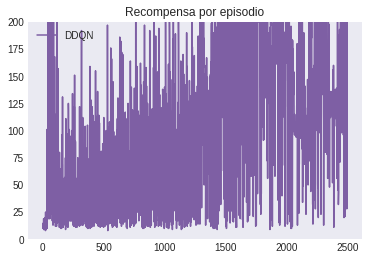

In [8]:
plt.plot(np.array(scores_DDQN), label='DDQN', c='#7e5fa4')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()


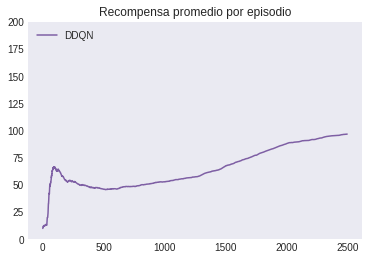

In [9]:
plt.plot(np.array(mean_DDQN), label='DDQN', c='#7e5fa4')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()


## Implementamos Dueling DQN

In [10]:
class DuelingNet(nn.Module):

    def __init__(self, _input_size: int, _output_size: int,
                 _hidden_layers: int, _hidden_size: int):
        super(DuelingNet, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        self.advantage = nn.Linear(_hidden_size, _output_size)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
        
        advantage = F.relu(self.advantage(x))
        x = self.output(x)
        return x + advantage - advantage.mean()


In [11]:
class DuelingDQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = DuelingNet(self.observation_space_size, self.action_space_size,
                                hidden_layers, hidden_size).to(self.device)
        self.target = DuelingNet(self.observation_space_size, self.action_space_size,
                                 hidden_layers, hidden_size).to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)


In [12]:
agent = DuelingDQN(gym.make('CartPole-v0'), n_episodes=n_episodes, debug=True)
scores_dueling_DQN, mean_dueling_DQN = agent.run()


[Episode 0] - Mean reward 10.0.
[Episode 100] - Mean reward 57.396039603960396.
[Episode 200] - Mean reward 59.81592039800995.
[Episode 300] - Mean reward 60.72425249169435.
[Episode 400] - Mean reward 58.55361596009975.
[Episode 500] - Mean reward 56.31936127744511.
[Episode 600] - Mean reward 57.33277870216306.
[Episode 700] - Mean reward 59.42225392296719.
[Episode 800] - Mean reward 62.410736579275905.
[Episode 900] - Mean reward 64.91675915649279.
[Episode 1000] - Mean reward 66.51848151848152.
[Episode 1100] - Mean reward 68.06085376930064.
[Episode 1200] - Mean reward 69.96253122398002.
[Episode 1300] - Mean reward 71.21137586471944.
[Episode 1400] - Mean reward 73.12062812276945.
[Episode 1500] - Mean reward 77.68487674883411.
[Episode 1600] - Mean reward 80.59900062460962.
[Episode 1700] - Mean reward 82.95061728395062.
[Episode 1800] - Mean reward 86.32204330927263.
[Episode 1900] - Mean reward 88.21883219358233.
[Episode 2000] - Mean reward 89.67816091954023.
[Episode 2100] 

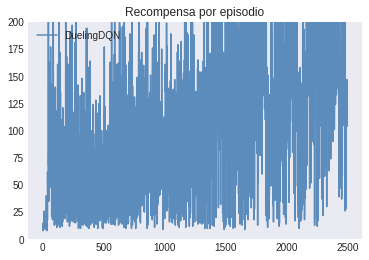

In [13]:
plt.plot(np.array(scores_dueling_DQN), label='DuelingDQN', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()


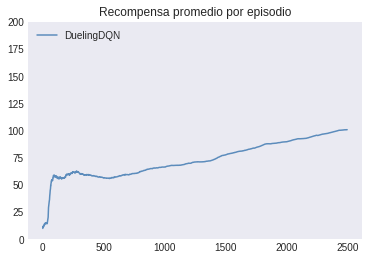

In [14]:
plt.plot(np.array(mean_dueling_DQN), label='DuelingDQN', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()


## Implementamos los modelos definidos anteriormente con otros entornos

El entorno que utilizaremos en este caso es el de Acrobot-v1

### Acrobot-v1 con DDQN

In [15]:
agent = DDQN(gym.make('Acrobot-v1'), n_episodes=n_episodes, debug=True)
scores_DDQN, mean_DDQN = agent.run()


[Episode 0] - Mean reward -500.0.
[Episode 100] - Mean reward -294.2277227722772.
[Episode 200] - Mean reward -258.16915422885575.
[Episode 300] - Mean reward -253.7607973421927.
[Episode 400] - Mean reward -252.7057356608479.
[Episode 500] - Mean reward -244.42914171656687.
[Episode 600] - Mean reward -246.67720465890184.
[Episode 700] - Mean reward -240.47503566333808.
[Episode 800] - Mean reward -231.2322097378277.
[Episode 900] - Mean reward -222.07436182019978.
[Episode 1000] - Mean reward -218.37462537462537.
[Episode 1100] - Mean reward -216.5431425976385.
[Episode 1200] - Mean reward -218.28226477935056.
[Episode 1300] - Mean reward -222.48962336664104.
[Episode 1400] - Mean reward -220.23197715917203.
[Episode 1500] - Mean reward -216.1292471685543.
[Episode 1600] - Mean reward -212.92004996876952.
[Episode 1700] - Mean reward -210.82422104644326.
[Episode 1800] - Mean reward -211.20655191560243.
[Episode 1900] - Mean reward -212.58442924776435.
[Episode 2000] - Mean reward -2

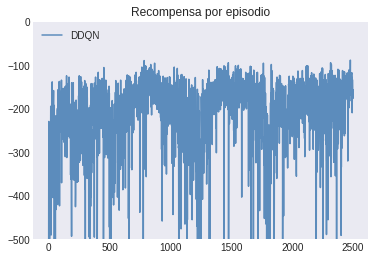

In [16]:
plt.plot(np.array(scores_DDQN), label='DDQN', c='#5c8cbc')
plt.ylim(-500, 0)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()


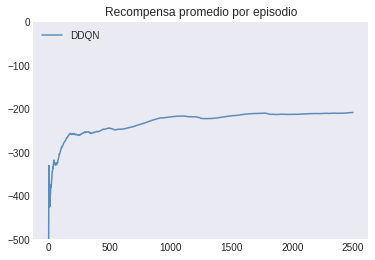

In [17]:
plt.plot(np.array(mean_DDQN), label='DDQN', c='#5c8cbc')
plt.ylim(-500, 0)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()


### Acrobot-v1 con Dueling DQN

In [18]:
agent = DuelingDQN(gym.make('Acrobot-v1'), n_episodes=n_episodes, debug=True)
scores_dueling_DQN, mean_dueling_DQN = agent.run()


[Episode 0] - Mean reward -500.0.
[Episode 100] - Mean reward -328.5049504950495.
[Episode 200] - Mean reward -323.76616915422886.
[Episode 300] - Mean reward -300.2126245847176.
[Episode 400] - Mean reward -282.25187032418955.
[Episode 500] - Mean reward -273.7245508982036.
[Episode 600] - Mean reward -262.56738768718805.
[Episode 700] - Mean reward -259.7589158345221.
[Episode 800] - Mean reward -259.2534332084894.
[Episode 900] - Mean reward -257.0610432852386.
[Episode 1000] - Mean reward -257.3736263736264.
[Episode 1100] - Mean reward -257.755676657584.
[Episode 1200] - Mean reward -254.30474604496254.
[Episode 1300] - Mean reward -250.9607993850884.
[Episode 1400] - Mean reward -249.80942184154176.
[Episode 1500] - Mean reward -250.26382411725515.
[Episode 1600] - Mean reward -252.08307307932543.
[Episode 1700] - Mean reward -251.73015873015873.
[Episode 1800] - Mean reward -250.97779011660188.
[Episode 1900] - Mean reward -250.10099947396108.
[Episode 2000] - Mean reward -251.3

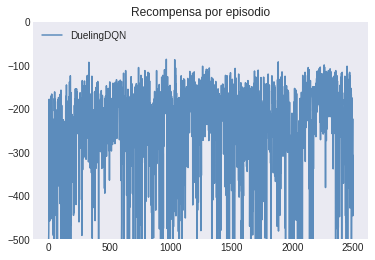

In [19]:
plt.plot(np.array(scores_dueling_DQN), label='DuelingDQN', c='#5c8cbc')
plt.ylim(-500, 0)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()


### 